<a href="https://colab.research.google.com/github/Marconiadsf/TechChallenger_2_Ibovespa/blob/main/Ibovespa_ETL%26FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliotecas
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

import warnings

warnings.filterwarnings("ignore")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Carregar os dados
df = pd.read_csv("Dados_Historicos_Ibovespa.csv", sep=",")
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.10.2025,149.540,148.774,149.636,148.774,"8,91B","0,51%"
1,30.10.2025,148.780,148.632,149.234,147.546,"7,30B","0,10%"
2,29.10.2025,148.633,147.430,149.067,147.430,"8,00B","0,82%"
3,28.10.2025,147.429,146.970,147.811,146.575,"7,11B","0,31%"
4,27.10.2025,146.969,146.174,147.977,146.174,"6,45B","0,55%"


In [4]:
df.shape

(752, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      752 non-null    object 
 1   Último    752 non-null    float64
 2   Abertura  752 non-null    float64
 3   Máxima    752 non-null    float64
 4   Mínima    752 non-null    float64
 5   Vol.      752 non-null    object 
 6   Var%      752 non-null    object 
dtypes: float64(4), object(3)
memory usage: 41.3+ KB


Base de dados 7 (?) features.

- Nescessário o tratamento de: Data, Vol., Var%
- Analisar amplitude das variáveis.  

In [6]:
#Converter valores em Vol.

df.dtypes

def convert_volume(volume_str):
    if isinstance(volume_str, str):
        volume_str = volume_str.replace(',', '.').strip()
        if 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1_000_000_000
        elif 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1_000_000
        elif 'K' in volume_str:
            return float(volume_str.replace('K', '')) * 1_000
        else:
            return float(volume_str)
    return volume_str

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

In [7]:
# Converter valores em Var%
df['Var%'] = df['Var%'].str.replace('%', '', regex=False)
df['Var%'] = df['Var%'].str.replace(',', '.', regex=False)
df['Var%'] = pd.to_numeric(df['Var%'], errors='coerce')
df['Var%'] = df['Var%'] / 100

In [8]:
#Tratamento das informações de Data
df["Data"] = pd.to_datetime(df["Data"],format="%d.%m.%Y")
df = df.sort_values(by="Data", ascending=True)



In [9]:
df.dtypes

Data        datetime64[ns]
Último             float64
Abertura           float64
Máxima             float64
Mínima             float64
Vol.               float64
Var%               float64
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 752 entries, 751 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      752 non-null    datetime64[ns]
 1   Último    752 non-null    float64       
 2   Abertura  752 non-null    float64       
 3   Máxima    752 non-null    float64       
 4   Mínima    752 non-null    float64       
 5   Vol.      752 non-null    float64       
 6   Var%      752 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 47.0 KB


Com os tratamentos básicos vamos verificar o comportamento do valor da Bovespa no intervalo analisado.

###Qual o intervalo dos dados?

In [11]:
print(df['Data'].min())
print(df['Data'].max())

2022-10-31 00:00:00
2025-10-31 00:00:00


## Vamos plotar um gráfico de linha e ver como os dados se comportam no tempo.

In [12]:
#Importar pyplot para gráficos:
import matplotlib.pyplot as plt



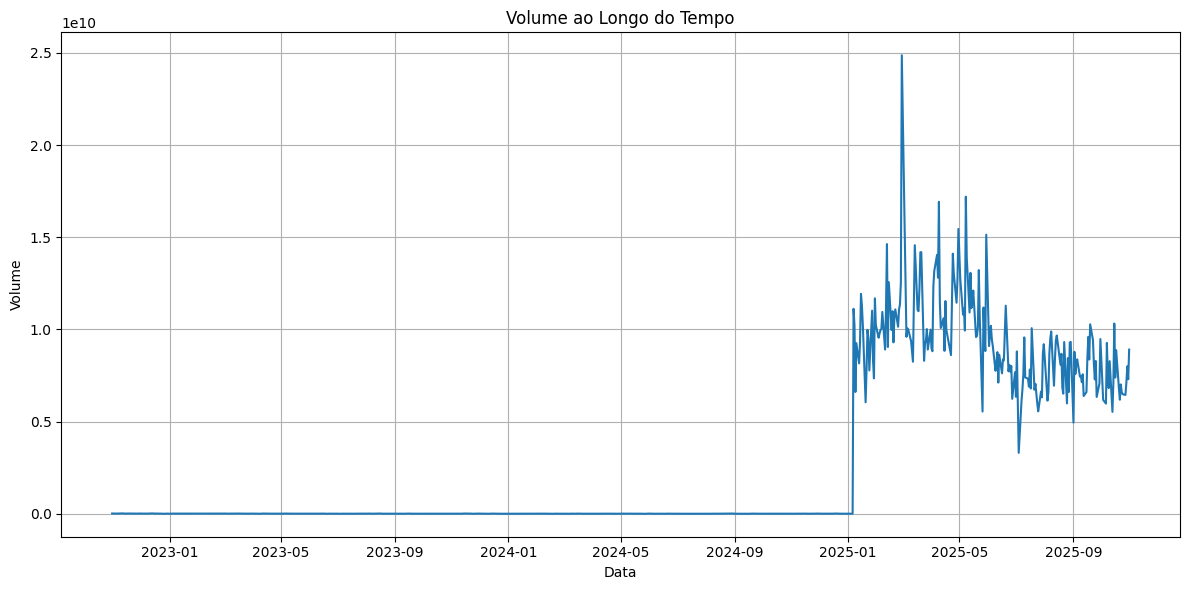

In [13]:
# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df['Data'], df['Vol.'])
plt.title('Volume ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

Algo de errado na base? O que aconteceu para esta diferença?

In [14]:
df['Vol.'].value_counts()

Vol.
9.370000e+06    6
6.610000e+09    4
9.950000e+06    4
9.990000e+06    4
9.140000e+06    3
               ..
1.943000e+07    1
1.175000e+07    1
1.639000e+07    1
1.017000e+07    1
7.300000e+09    1
Name: count, Length: 613, dtype: int64

In [15]:
df['Vol.'].tail()

4    6.450000e+09
3    7.110000e+09
2    8.000000e+09
1    7.300000e+09
0    8.910000e+09
Name: Vol., dtype: float64

In [16]:
df['Vol.'].head()

751    21640000.0
750    17970000.0
749    15630000.0
748    16210000.0
747    15220000.0
Name: Vol., dtype: float64

In [17]:
print(df['Vol.'].min())
print(df['Vol.'].max())

4330000.0
24870000000.0


Hum... parece que pode ser realmente um salto no valor de negiciação em 2025 gerando uma diferença de escala. Vamos analisar essa coluna em especifico...


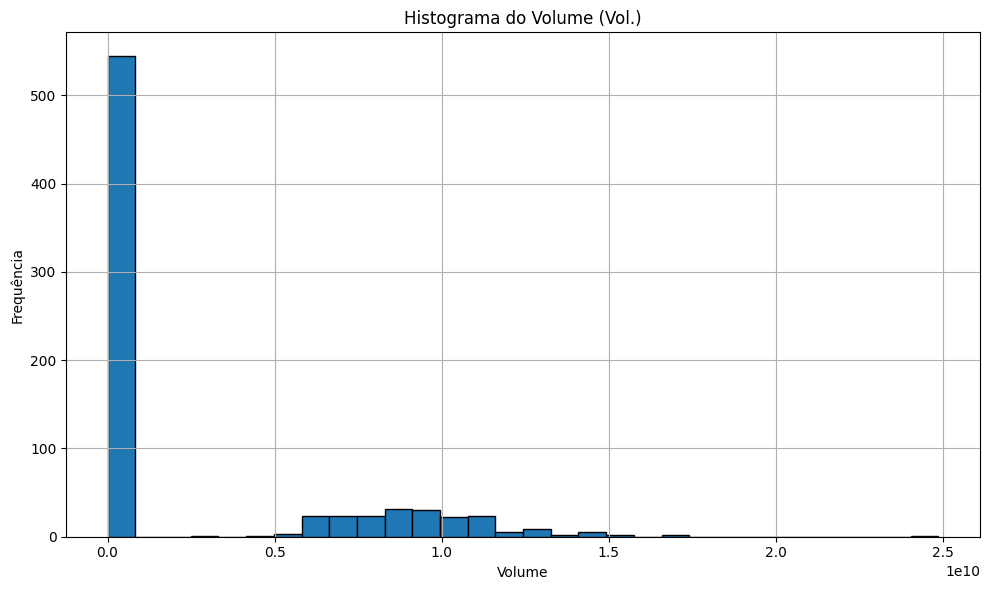

In [18]:
# Gerar um histograma para a coluna 'Vol.'

plt.figure(figsize=(10, 6))
plt.hist(df['Vol.'], bins=30, edgecolor='black') # bins define o número de barras
plt.title('Histograma do Volume (Vol.)')
plt.xlabel('Volume')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

Dificil até de ver essa  freq. de distribuição, realmente os dados não parecem nada homogêneos. Tentando aplicar a raiz quadrada sobre os dados e plotar....

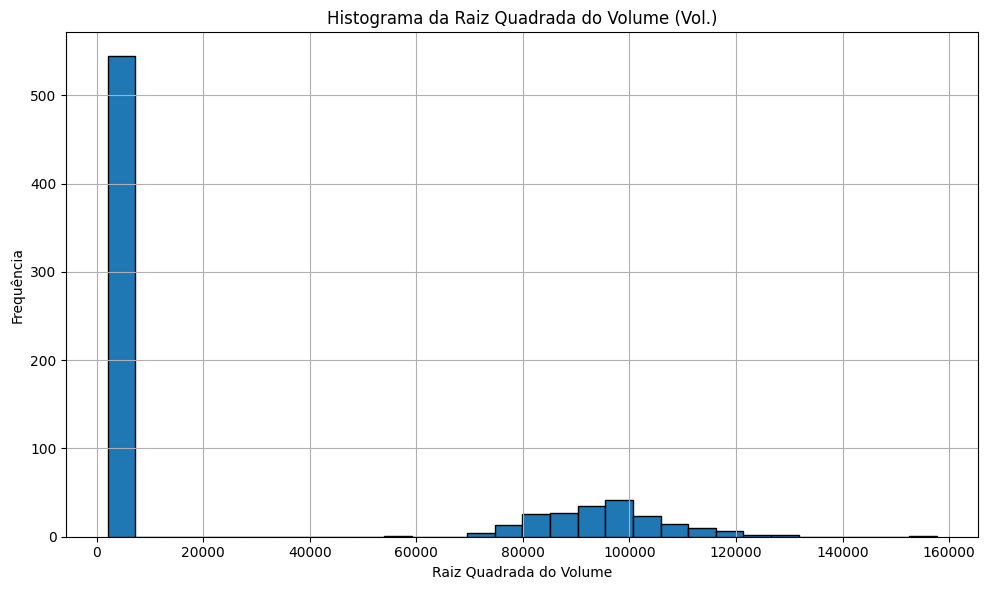

In [19]:
import numpy as np


# Aplicar a raiz quadrada na coluna 'Vol.'
df['Vol._sqrt'] = np.sqrt(df['Vol.'])

# Gerar um histograma para a coluna transformada 'Vol._sqrt'
plt.figure(figsize=(10, 6))
plt.hist(df['Vol._sqrt'], bins=30, edgecolor='black') # bins define o número de barras
plt.title('Histograma da Raiz Quadrada do Volume (Vol.)')
plt.xlabel('Raiz Quadrada do Volume')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

Hum..continua complicado... olhando o boxplot...

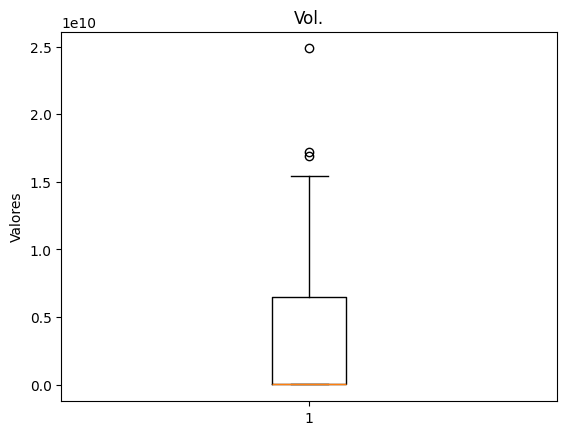

In [20]:
# Criar o gráfico de boxplot
plt.boxplot(df['Vol.'])
plt.title('Vol.')
plt.ylabel('Valores')
plt.show()

Investigar o por que da diferença entre 2024 e 2025 nos volumes negociados.
Olhar o boxplot das outras variáveis

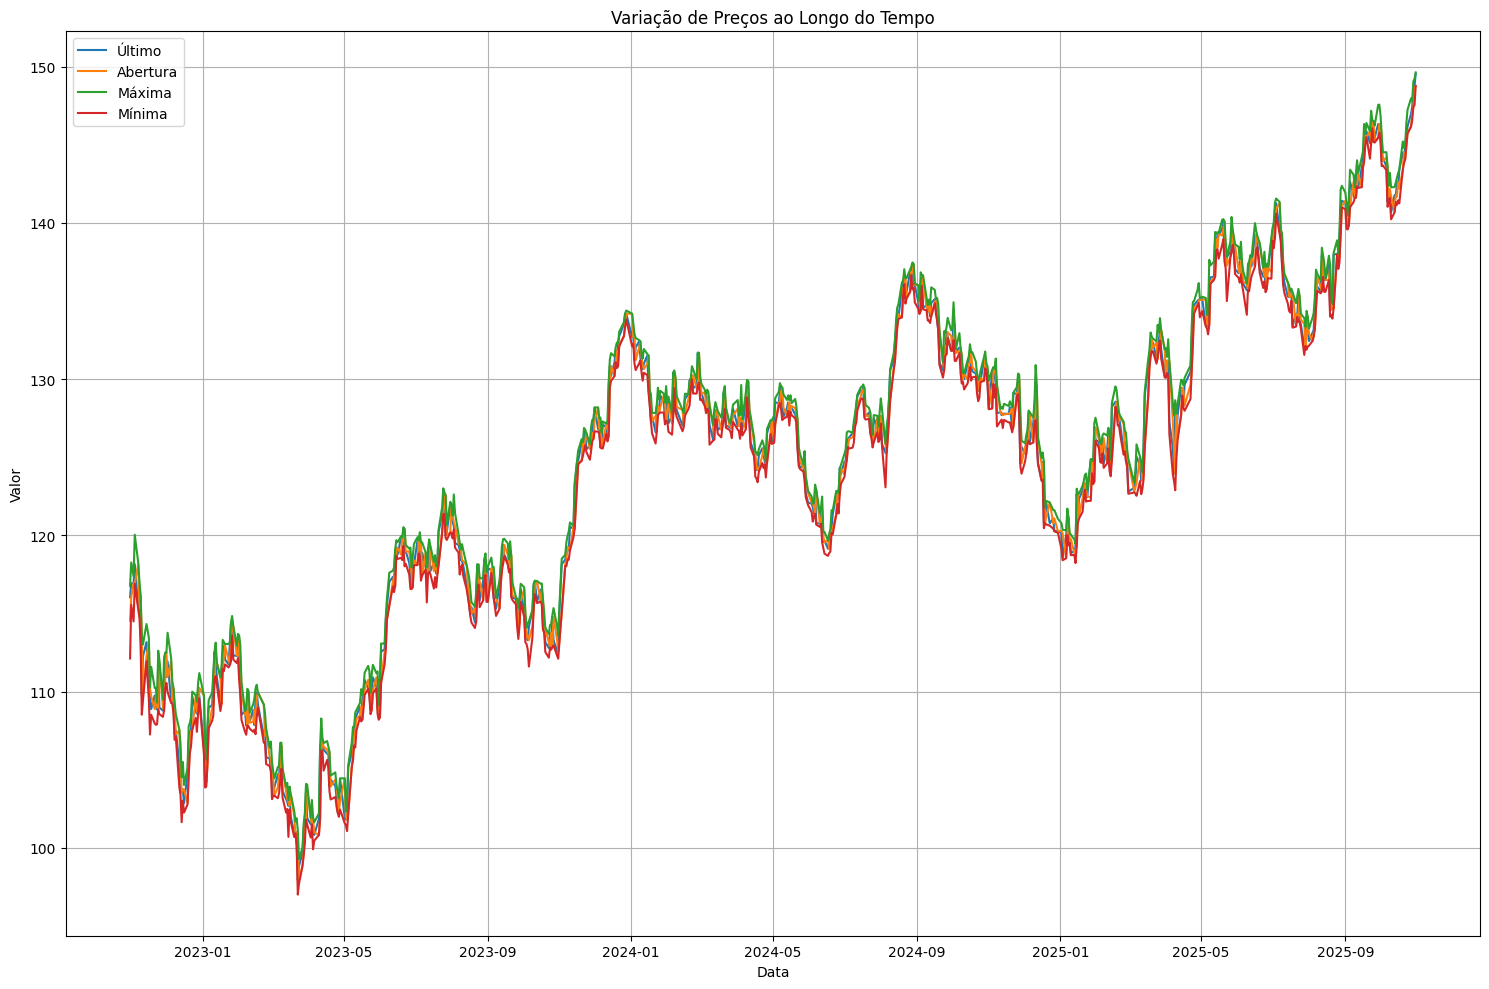

In [21]:
columns_to_plot = ['Último', 'Abertura', 'Máxima', 'Mínima']

plt.figure(figsize=(15, 10))

for column in columns_to_plot:
    plt.plot(df['Data'], df[column], label=column)

plt.title('Variação de Preços ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretação:

As variáveis/colunas/features Último, Abertura, Mínimo e Máximo andam próximas. Vou interpretar o seguinte:
1. Último é o fechamento do dia. Pode assumir qualquer valor entre [Mínimo,Máximo]
2. Mínimo e Máximo são respectivamente o menor e maior valor atingidos em um dia.
3. Sendo assim Máximo - Mínimo é a máxima variação/oscliação intraday, já Último - Abertura a variação efetiva do dia e o que gera a Var% e logo se o dia fechou em baixa (Último-Abertura <0) ou alta (Último-Abertura > 0)


Agora olhando o boxplot dessas features:

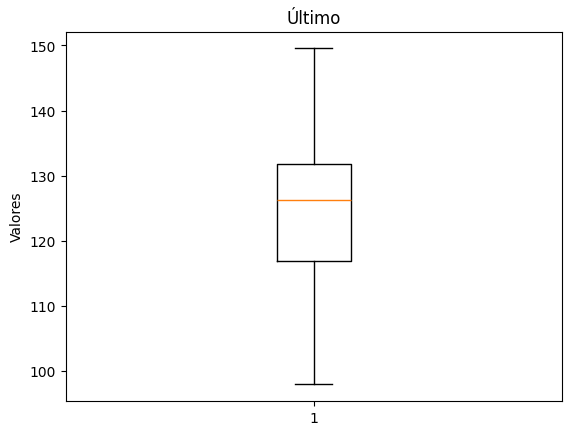

In [51]:
# Criar o gráfico de boxplot
plt.boxplot(df['Último'])
plt.title('Último')
plt.ylabel('Valores')
plt.show()

In [23]:
print(df['Último'].min())
print(df['Último'].max())

97.926
149.54


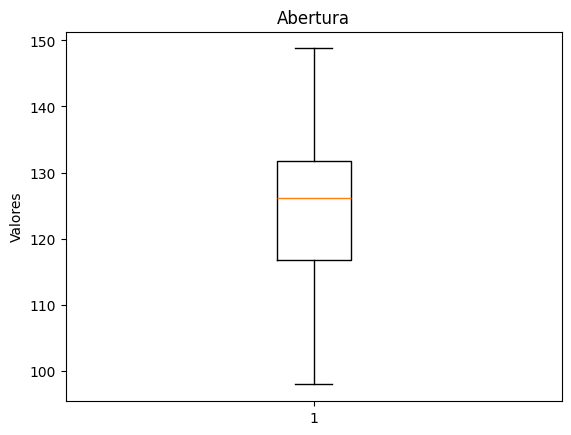

In [24]:
# Criar o gráfico de boxplot
plt.boxplot(df['Abertura'])
plt.title('Abertura')
plt.ylabel('Valores')
plt.show()

In [25]:
print(df['Abertura'].min())
print(df['Abertura'].max())

97.926
148.774


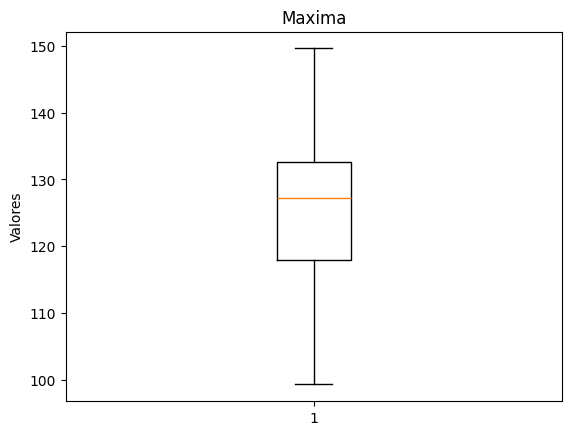

In [26]:
# Criar o gráfico de boxplot
plt.boxplot(df['Máxima'])
plt.title('Maxima')
plt.ylabel('Valores')
plt.show()

In [27]:
print(df['Máxima'].min())
print(df['Máxima'].max())

99.258
149.636


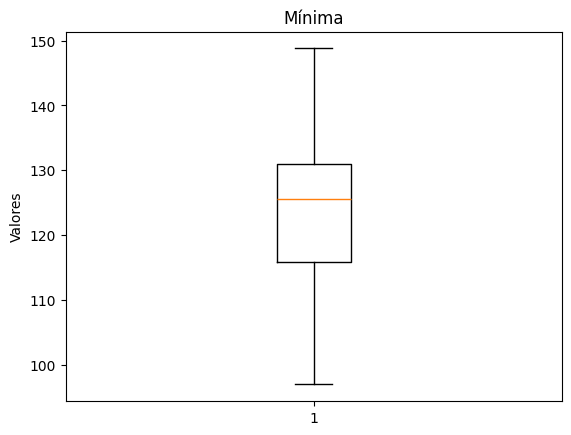

In [28]:
# Criar o gráfico de boxplot
plt.boxplot(df['Mínima'])
plt.title('Mínima')
plt.ylabel('Valores')
plt.show()

In [29]:
print(df['Mínima'].min())
print(df['Mínima'].max())

96.997
148.774


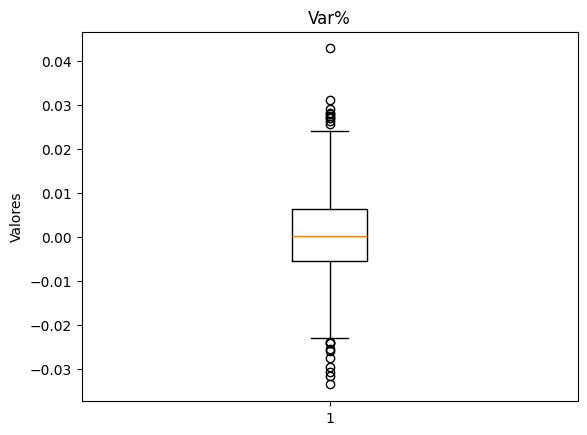

In [30]:
# Criar o gráfico de boxplot
plt.boxplot(df['Var%'])
plt.title('Var%')
plt.ylabel('Valores')
plt.show()

In [31]:
print(df['Var%'].min())
print(df['Var%'].max())

-0.0335
0.0429


Conclusão (Responder):
- As escalas são diferentes? R: Principalmente em Vol. os valores variam significativamente. Além disso a escala dessa coluna em relação as demais é bem diferente....
- Alguma categoria precisa de transformação?
- Quais features precisam ser criadas/alteradas ?
  - R: Criar:
    - Tendencia
    - Var. Diária
    - Médias móveis (geralmente usado em análise de graficos de candle para uma ação qualquer na bolsa, cryptos e outros ativos financeiros - definir quantas e quais intervalos)

In [32]:
#Criando a coluna tendência

df['Tendencia'] = np.select(
    [df['Var%'] > 0, df['Var%'] < 0],
    ['Alta', 'Baixa'],
    default='Estável' # Assuming 0 can be 'Estável' or handle as needed
)
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Vol._sqrt,Tendencia
751,2022-10-31,116.037,114.533,116.763,112.113,21640000.0,0.0131,4651.881340,Alta
750,2022-11-01,116.929,116.037,118.261,115.547,17970000.0,0.0077,4239.103679,Alta
749,2022-11-03,116.896,116.927,117.373,114.485,15630000.0,-0.0003,3953.479480,Baixa
748,2022-11-04,118.155,116.907,120.039,116.904,16210000.0,0.0108,4026.164428,Alta
747,2022-11-07,115.342,118.148,118.240,115.221,15220000.0,-0.0238,3901.281841,Baixa


In [33]:
#Criando a média móvel
df['Media_Movel_5_dias'] = df['Último'].rolling(window=5, min_periods=1).mean()
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Vol._sqrt,Tendencia,Media_Movel_5_dias
751,2022-10-31,116.037,114.533,116.763,112.113,21640000.0,0.0131,4651.881340,Alta,116.037000
750,2022-11-01,116.929,116.037,118.261,115.547,17970000.0,0.0077,4239.103679,Alta,116.483000
749,2022-11-03,116.896,116.927,117.373,114.485,15630000.0,-0.0003,3953.479480,Baixa,116.620667
748,2022-11-04,118.155,116.907,120.039,116.904,16210000.0,0.0108,4026.164428,Alta,117.004250
747,2022-11-07,115.342,118.148,118.240,115.221,15220000.0,-0.0238,3901.281841,Baixa,116.671800


In [34]:
df['Diferenca_Ultimo_Abertura'] = df['Último'] - df['Abertura']
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Vol._sqrt,Tendencia,Media_Movel_5_dias,Diferenca_Ultimo_Abertura
751,2022-10-31,116.037,114.533,116.763,112.113,21640000.0,0.0131,4651.881340,Alta,116.037000,1.504
750,2022-11-01,116.929,116.037,118.261,115.547,17970000.0,0.0077,4239.103679,Alta,116.483000,0.892
749,2022-11-03,116.896,116.927,117.373,114.485,15630000.0,-0.0003,3953.479480,Baixa,116.620667,-0.031
748,2022-11-04,118.155,116.907,120.039,116.904,16210000.0,0.0108,4026.164428,Alta,117.004250,1.248
747,2022-11-07,115.342,118.148,118.240,115.221,15220000.0,-0.0238,3901.281841,Baixa,116.671800,-2.806


In [35]:
#Criar uma coluna sequencial aproveitando que os dados foram organizados por data anteriormente
df['Sequential_ID'] = range(len(df))
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Vol._sqrt,Tendencia,Media_Movel_5_dias,Diferenca_Ultimo_Abertura,Sequential_ID
751,2022-10-31,116.037,114.533,116.763,112.113,21640000.0,0.0131,4651.881340,Alta,116.037000,1.504,0
750,2022-11-01,116.929,116.037,118.261,115.547,17970000.0,0.0077,4239.103679,Alta,116.483000,0.892,1
749,2022-11-03,116.896,116.927,117.373,114.485,15630000.0,-0.0003,3953.479480,Baixa,116.620667,-0.031,2
748,2022-11-04,118.155,116.907,120.039,116.904,16210000.0,0.0108,4026.164428,Alta,117.004250,1.248,3
747,2022-11-07,115.342,118.148,118.240,115.221,15220000.0,-0.0238,3901.281841,Baixa,116.671800,-2.806,4


In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustar e transformar os rótulos
df['Tendencia'] = label_encoder.fit_transform(df['Tendencia'])

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Vol._sqrt,Tendencia,Media_Movel_5_dias,Diferenca_Ultimo_Abertura,Sequential_ID
751,2022-10-31,116.037,114.533,116.763,112.113,21640000.0,0.0131,4651.881340,0,116.037000,1.504,0
750,2022-11-01,116.929,116.037,118.261,115.547,17970000.0,0.0077,4239.103679,0,116.483000,0.892,1
749,2022-11-03,116.896,116.927,117.373,114.485,15630000.0,-0.0003,3953.479480,1,116.620667,-0.031,2
748,2022-11-04,118.155,116.907,120.039,116.904,16210000.0,0.0108,4026.164428,0,117.004250,1.248,3
747,2022-11-07,115.342,118.148,118.240,115.221,15220000.0,-0.0238,3901.281841,1,116.671800,-2.806,4



#Daqui por diante são o passo a passo do notebook de Aula sobre regressões, não foi revisado/adaptado.
______________

OK, como próximo passo, antes de normalizar ou padronizar, vamos separar os dados em treino e teste:

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Tendencia','Var%', 'Vol.', 'Vol._sqrt','Abertura','Máxima','Mínima','Data' ]) # Variáveis características
y = df['Tendencia'] # O que eu quero prever. (Target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Aplicando MinMax Scaler**

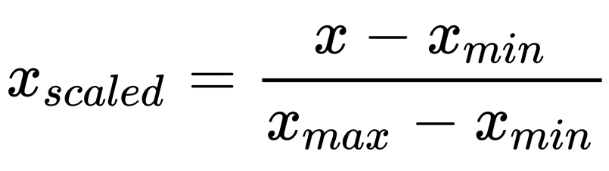

O escalonamento min-max (normalização) é muito simples! Basicamente os valores são deslocados e redimensionados para que acabem variando de 0 a 1. Observe a fórmula a seguir, esse cálculo subtrai o valor mínimo e divide pelo máximo, menos o mínimo.


In [39]:
scaler = MinMaxScaler() #chamando o metodo de normalização dos dados (0-1)

scaler.fit(X_train)

x_train_min_max_scaled = scaler.transform(X_train)
x_test_min_max_scaled= scaler.transform(X_test)

In [40]:
x_train_min_max_scaled

array([[0.52522571, 0.49811454, 0.67595273, 0.77896138],
       [0.20416941, 0.16281847, 0.49867342, 0.17443409],
       [0.14352695, 0.15676201, 0.61432706, 0.05858855],
       ...,
       [0.56970977, 0.5483593 , 0.61384467, 0.35952064],
       [0.54661526, 0.55524872, 0.37566329, 0.5792277 ],
       [0.07492153, 0.00721768, 0.54691269, 0.13581891]], shape=(601, 4))

Mas você deve estar se perguntando:

*“por que é realizado o escalonamento (fit) na base treino e não na base de teste?”.*

Bem, realizamos a transformação do escalonamento na base de treino para **evitar que a base de teste fique exatamente igual às estatísticas da base de treino**, o que evita **“vazamento”** desses dados. A base de teste em geral deve representar uma base de dados nunca vista antes pelo algoritmo, justamente para testar se o algoritmo consegue generalizar os dados.


Agora vamos testar com **StandarScaler**.

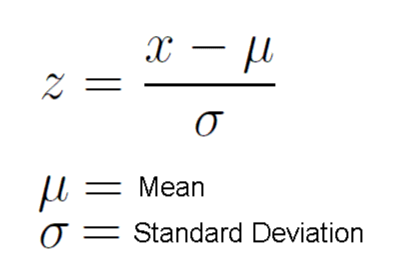

A padronização não vincula valores específicos nos mínimos e máximos, o que pode ser um ponto de atenção em alguns algoritmos (por exemplo, redes neurais). No entanto, a padronização é muito menos afetada por outliers.  Na biblioteca do Scikit-Learn temos a padronização em StandardScaler.




In [41]:
scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

scaler.fit(X_train)# qual média e std será utilizado para o escalonamento

x_train_standard_scaled = scaler.transform(X_train)
x_test_standard_scaled  = scaler.transform(X_test)

In [42]:
x_train_standard_scaled

array([[ 0.06144665, -0.03941995,  1.3601116 ,  0.95784675],
       [-1.45153991, -1.5434088 ,  0.11283345, -1.13758173],
       [-1.73731916, -1.57057535,  0.92653396, -1.5391286 ],
       ...,
       [ 0.27107897,  0.18595567,  0.92314   , -0.49602984],
       [ 0.16224546,  0.21685854, -0.75262486,  0.26552457],
       [-2.06062406, -2.24136461,  0.45222886, -1.27143069]],
      shape=(601, 4))

In [43]:
from sklearn.neighbors import KNeighborsClassifier

Vamos testar o algoritmo sem os escalonadores e validar os resultados!

# K-Nearest Neighbors (KNN)

In [44]:
model = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.61


Testando com a normalização:

In [46]:
model_min_max = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model_min_max.fit(x_train_min_max_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred_min_max = model.predict(x_test_min_max_scaled)

accuracy_min_max = accuracy_score(y_test, y_pred_min_max)
print(f'Acurácia: {accuracy_min_max:.2f}')

Acurácia: 0.54


Testando com a padronização

In [47]:
model_standard = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
model_standard.fit(x_train_standard_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred_standard = model.predict(x_test_standard_scaled)

accuracy_strandard = accuracy_score(y_test, y_pred_standard)
print(f'Acurácia: {accuracy_strandard:.2f}')

Acurácia: 0.54
